In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False



from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength
from transforms import transforms
from Decon import SpectralDecon
from sigmaSolver import sigma_Solver


from SignalAttenuation import Attenuation
from SignalAttenuation import AnnualLayerThick

In [301]:
site = 'SiteG'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


In [302]:
lSecs = 5

depthALT = np.asarray(depth)
d18OALT = np.asarray(d18O)

inst = AnnualLayerThick(depthALT, d18OALT, lSecs)
fksMax, ls, lMean, lStd, vals = inst.ALT_fullCore()
vals_use = vals[:-1]

l_LT = np.mean(lMean[(vals_use > dTamb) & (vals_use < dLaki)])

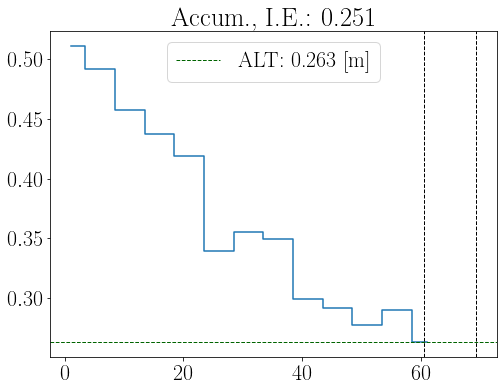

In [303]:
fig, ax = plt.subplots(figsize=(8,6))
ax.step(vals[:-1], lMean, where='mid')
ax.axvline(dTamb, c='k', ls='--',lw=1)
ax.axvline(dLaki, c='k', ls='--',lw=1)
ax.axhline(l_LT, c='darkgreen', lw=1, ls='--', label=f'ALT: {l_LT:.3f} [m]')
ax.set(title=f'Accum., I.E.: {accumIE:.3f}')
ax.legend()

In [359]:
ALT = l_LT
yrs = min(depth_LT) + ALT * np.arange(0,34)

pALT = ALT * len(depth_LT)/(max(depth_LT)-min(depth_LT))

dist = np.floor(pALT*(3/4))

promP1 = np.std(d18O_LT/2)
promT1 = np.std(d18O_LT/2)
peaks, props = signal.find_peaks(d18O_LT, distance = dist, prominence=promP1)
peaks2, props2 = signal.find_peaks(-d18O_LT, distance=dist, prominence=promT1)

In [360]:
dist

4.0

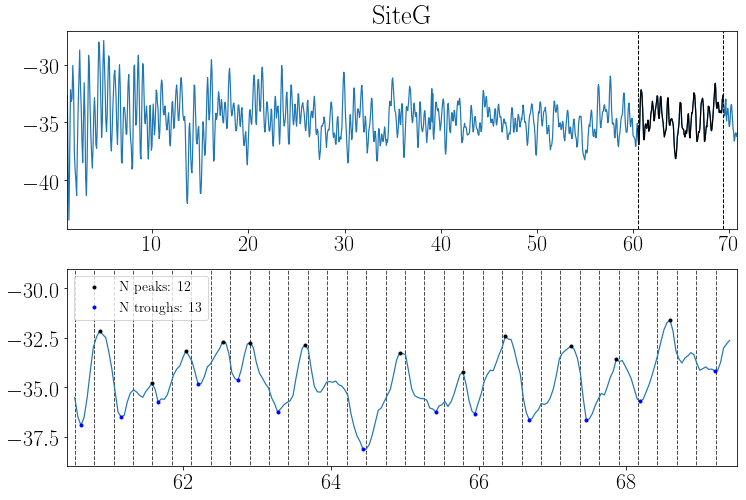

In [306]:
fig, ax = plt.subplots(2,1,figsize=(12,8))
ax[0].plot(depth,d18O, lw=1.2)
ax[0].plot(depth_LT,d18O_LT,c='k', lw=1.2)
ax[0].set(xlim=(min(depth), max(depth)), title=site)
ax[0].axvline(min(depth_LT), c='k', lw=1, ls='--')
ax[0].axvline(max(depth_LT), c='k', lw=1, ls='--')


ax[1].plot(depth_LT,d18O_LT, lw=1.2)


ax[1].plot(np.asarray(depth_LT)[peaks],np.asarray(d18O_LT)[peaks],'.', c='k', label=f'N peaks: {len(peaks)}')
ax[1].plot(np.asarray(depth_LT)[peaks2],np.asarray(d18O_LT)[peaks2],'.', c='b', label=f'N troughs: {len(peaks2)}')
ax[1].vlines(yrs, -40, -25, lw=1, ls='--', alpha = 0.7)
ax[1].set(xlim=(min(depth_LT)-0.1, max(depth_LT)+0.1), ylim=(-39,-29))
ax[1].legend(fontsize=14)

In [307]:
inst = BackDiffuse(site, data_d18O, CoresSpecs, dTamb, dLaki, 33, diffLenData=data_diff_LT, densData=data_dens_LT)

In [326]:
sigma_rangeHL = inst.diffLenEstimateHL()
sigma_FitEst = inst.spectralEstimate()

dInt, d18OInt, Delta = inst.interpCores()

diffLen0 = min(min(sigma_rangeHL), sigma_FitEst) - 0.02 + 0.03403
print(f'Sigma fit: {sigma_FitEst*100:.2f}')
print(f'Min sigma analyt: {min(sigma_rangeHL)*100:.2f}')
print(f'\nStarting sigma: {diffLen0*100:.2f} [cm]')

transType_in = 'DCT'

decon_inst = SpectralDecon(dInt, d18OInt, N_min=2000, transType=transType_in)

depth0, dataD0 = decon_inst.deconvolve(diffLen0)



dist = np.floor(pALT*(2/4))
min_peakDist = dist
promT = np.std(dataD0)*2/5
promP = np.std(dataD0)*2/5


idxPeak = signal.find_peaks(dataD0, distance = min_peakDist, prominence=promP)[0]
idxTrough = signal.find_peaks(-dataD0, distance = min_peakDist, prominence=promT)[0]

print('Peaks: ' + str(len(idxPeak)))
print('Troughs: ' + str(len(idxTrough)))

Sigma fit: 8.33
Min sigma analyt: 8.85

Starting sigma: 9.73 [cm]
Peaks: 33
Troughs: 33


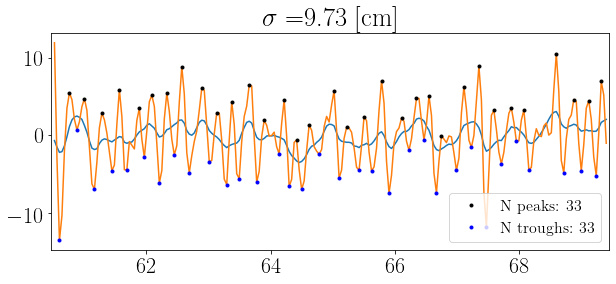

In [327]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(dInt, d18OInt-np.mean(d18OInt))
ax.plot(depth0,dataD0)
ax.plot(depth0[idxPeak], dataD0[idxPeak],'.', color='k', label=f'N peaks: {len(idxPeak)}')
ax.plot(depth0[idxTrough], dataD0[idxTrough],'.', color='b', label=f'N troughs: {len(idxTrough)}')

ax.set(xlim=(min(depth0)-0.05, max(depth0)+0.05), title='$\sigma = $'+f'{diffLen0*100:.2f} [cm]')
ax.legend(fontsize=16)

In [344]:
peaksBD = sp.signal.find_peaks(dataD0, distance = min_peakDist, prominence=promP)[0]
troughsBD = sp.signal.find_peaks(-dataD0, distance = min_peakDist, prominence=promT)[0]

peaksBD_lst = np.ones(len(peaksBD))#['P'] * len(peaksBD)
troughsBD_lst = np.zeros(len(troughsBD))#['T'] * len(troughsBD)


exts = np.concatenate((peaksBD,troughsBD))
exts_lst = np.concatenate((peaksBD_lst,troughsBD_lst))
list1, list2 = (np.array(t) for t in zip(*sorted(zip(exts, exts_lst))))


if len(list1)%2 != 0:
    if list2[0] == 1:
        listNew_lst = np.append(list2,-1)
        listNew = np.append(list1,0)
    elif list2[0] == 0:
        listNew_lst = np.insert(list2,0,-1)
        listNew = np.insert(list1,0,0)
else:
    listNew_lst = list2
    listNew = list1
    


PTs = listNew_lst.reshape((int(len(listNew_lst)/2)),2)
PTs_idx = listNew.reshape((int(len(listNew)/2)),2)

In [345]:
listNew_lstPos = listNew_lst[listNew_lst>=0]
if listNew_lstPos[0] == 1:
    listNew_Ps = listNew_lstPos[::2]
    listNew_Ts = listNew_lstPos[1::2]
elif listNew_lstPos[0] == 0:
    listNew_Ps = listNew_lstPos[1::2]
    listNew_Ts = listNew_lstPos[::2]

In [346]:
if (sum(listNew_Ps) == len(peaksBD)) & (sum(listNew_Ts) == 0):
    pattern = True
    patternStart = listNew_lstPos[0]
    patternEnd = listNew_lstPos[-1]
else:
    pattern = False
    patternStart = []
    patternEnd = []
pattern

True

In [392]:
def find_constrainedPeaks(data, dist, prom):
    
        # Find peaks and troughs in data, given distance and prominence provided
    peaksBD = sp.signal.find_peaks(data, distance = dist, prominence=prom)[0]
    troughsBD = sp.signal.find_peaks(-data, distance = dist, prominence=prom)[0]

    
        # Create lists of ones (representing peaks) and zeros (representing troughs)
    peaksBD_lst = np.ones(len(peaksBD))
    troughsBD_lst = np.zeros(len(troughsBD))

    
        # Create array containing (unsorted) peaks and troughs positions and corresponding P (1) or T (0).
    exts = np.concatenate((peaksBD,troughsBD))
    exts_lst = np.concatenate((peaksBD_lst,troughsBD_lst))
        # Sort both lists at the same time, thus matching up idxs and P/T (1/0) value
    list1, list2 = (np.array(t) for t in zip(*sorted(zip(exts, exts_lst))))

    
        # Check if list is divisible by two. If not, append P/T array with -1 and idx array with 0
        # at either first or last position depending on starting with P (1) or T (0)
    if len(list1)%2 != 0:
        if list2[0] == 1:
            listNew_lst = np.append(list2,-1)
            listNew = np.append(list1,0)
        elif list2[0] == 0:
            listNew_lst = np.insert(list2,0,-1)
            listNew = np.insert(list1,0,0)
    else:
        listNew_lst = list2
        listNew = list1
    
    
        # Reshape arrays into 2 x len(Ps/Ts)
    PTs = listNew_lst.reshape((int(len(listNew_lst)/2)),2)
    PTs_idx = listNew.reshape((int(len(listNew)/2)),2)
    
    
        # Get only positive values from list (remove the appended values from earlier)
    listNew_lstPos = listNew_lst[listNew_lst>=0]
    listNew_Pos = listNew[listNew_lst>=0]

    
        # If the first value in the array is a peak (1), make lists with all (estimated) peaks (every second
        # element) and all troughs (every second + 1 element)
    if listNew_lstPos[0] == 1:
        
        listNew_lstPs = listNew_lstPos[::2]
        listNew_Ps = listNew_Pos[::2]
        
        listNew_lstTs = listNew_lstPos[1::2]
        listNew_Ts = listNew_Pos[1::2]
        
        # If the first value in the array is a trough (0), make list with all (estimated) peaks (every second
        # + 1 element) and all troughs (every second element)
    elif listNew_lstPos[0] == 0:
        listNew_lstPs = listNew_lstPos[1::2]
        listNew_Ps = listNew_Pos[1::2]
        
        listNew_lstTs = listNew_lstPos[::2]
        listNew_Ts = listNew_Pos[::2]
        
        
        # Check if [..PTPTPTPTPT..] pattern exists by summing all estimated peaks and checking if sum(P) == len(Ps)
        # and summing all estimated troughs and checking if sum(T) == 0
        # If so, return pattern = True and what the pattern starts and ends with (P=1 and T=0)
    
    if (sum(listNew_lstPs) == len(peaksBD)) & (sum(listNew_lstTs) == 0):
        pattern = True
        patternStart = listNew_lstPos[0]
        patternEnd = listNew_lstPos[-1]
        # If not, return pattern = False and start and end as empty lists.
    else:
        pattern = False
        patternStart = []
        patternEnd = []

    return pattern, patternStart, patternEnd, listNew_Ps, listNew_Ts

In [393]:
N_peaks = 0
N_troughs = 0

depth = depth0
data = dataD0
diffLen = diffLen0

arr_diffLens = []
arr_Npeaks = []
arr_depth = []
arr_data = []
i = 0



In [394]:
inst = BackDiffuse(site, data_d18O, CoresSpecs, dTamb, dLaki, 33, diffLenData=data_diff_LT, densData=data_dens_LT)

In [414]:
round(min(np.diff(depth_LT)),3)/4

0.01

In [464]:
vals = [-0.01,0.01,0.03,0.05]
vals2 = [0.03553333]# np.linspace(0.0354, 0.0356,10)

In [465]:
sigma_rangeHL = inst.diffLenEstimateHL()
sigma_FitEst = inst.spectralEstimate()

dInt, d18OInt, Delta = inst.interpCores()


In [466]:
vals2

[0.03553333]

In [467]:

print('\n\n###############\n')
diffLen0 = min(min(sigma_rangeHL), sigma_FitEst) - 0.02 + 0.03
print(f'Min sigma analyt: {min(sigma_rangeHL)*100:.2f}')
print(f'Starting sigma: {diffLen0*100:.2f} [cm]')

transType_in = 'DCT'

decon_inst = SpectralDecon(dInt, d18OInt, N_min=2000, transType=transType_in)

depth0, dataD0 = decon_inst.deconvolve(diffLen0)



dist = np.floor(pALT*(2/4))
min_peakDist = dist
promT = np.std(dataD0)*2/4
promP = np.std(dataD0)*2/4

pattern, start, end, Ps, Ts = find_constrainedPeaks(dataD0, min_peakDist, promP)

print('\n\nRight pattern?: ' + str(pattern))
print('\nN peaks: ' + str(len(Ps)))
print('N troughs: ' + str(len(Ts)))



###############

Min sigma analyt: 8.85
Starting sigma: 9.88 [cm]


Right pattern?: True

N peaks: 33
N troughs: 33


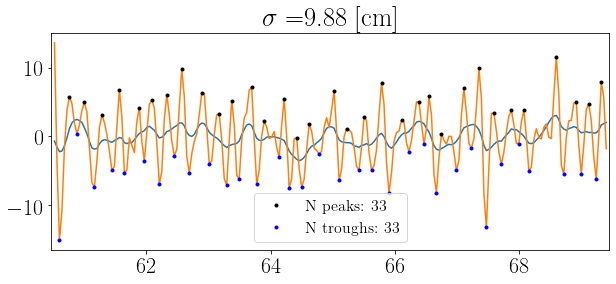

In [468]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(dInt, d18OInt-np.mean(d18OInt))
ax.plot(depth0,dataD0)
ax.plot(depth0[Ps], dataD0[Ps],'.', color='k', label=f'N peaks: {len(Ps)}')
ax.plot(depth0[Ts], dataD0[Ts],'.', color='b', label=f'N troughs: {len(Ts)}')

ax.set(xlim=(min(depth0)-0.05, max(depth0)+0.05), title='$\sigma = $'+f'{diffLen0*100:.2f} [cm]')
ax.legend(fontsize=16)

In [401]:
Ts

array([  3,  16,  30,  42,  55,  69,  82,  99, 121, 135, 153, 173, 191,
       204, 216])